In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd

import zipfile
import tensorflow

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [3]:
# Versão do tensorflow

tensorflow.__version__

'2.5.0'

In [4]:
# Drive do Google
from google.colab import drive

colab_drive = drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Dados do drive

path = "/content/gdrive/MyDrive/Cursos/Udemy/Visão Computacional/Projeto VC/Material.zip"
object_zip = zipfile.ZipFile(file = path, mode = "r")
object_zip.extractall("./")
object_zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/gdrive/MyDrive/Cursos/Udemy/Visão Computacional/Projeto VC/Material.zip' mode='r'>>

In [12]:
# Arquivos dos haarcascade
cascade_faces = 'Material/haarcascade_frontalface_default.xml'
caminho_modelo = 'Material/modelo_01_expressoes.h5'
face_detection = cv2.CascadeClassifier(cascade_faces)
classificador_emocoes = load_model(caminho_modelo, compile=False)

# Modelo
face_detection = cv2.CascadeClassifier(cascade_faces)
classificador_emocoes = load_model(caminho_modelo, compile=False)

### Carregar biblioteca e função

Essa parte é uma mistura de python com javascript e HTML. Primeiro é criado no HTML a tag `video` que é onde estará sendo exibido a imagem capturada pela webcam (se quiser visualizar isso em tempo real clique com o botão direito sobre o quadrado onde está exibindo a imagem da webcam e selecione "Inspecionar")
 
Em seguida é iniciada a tag `script`, e é dentro dessa tag onde será colocado todo o código javascript, ou seja, javascript é tudo que está entre `<script></script>`

A webcam é gerenciada pela função `navigator.mediaDevices.getUserMedia`, que além de gerenciar essa comunicação é responsável por transmitir a imagem recebida pela câmera e adicionar as imagens do frame dentro da tag video.

A variável `data` vai receber uma Promise, que no javascript é um objeto usado para processamento assíncrono (esse objeto guarda um valor que pode estar disponível agora, futuramente ou nunca. Isso permite o tratamento de eventos ou ações que acontecem de forma assíncrona (como é nesse caso) em casos de sucessos ou falhas) esse objeto será responsável por fazer o seguinte: 
ao ser identificado um click sobre a imagem (na tag `<video>`), `video.onclick`
pega o frame atual e adiciona ele dentro de um canvas, com a largura e altura especificadas `canvas.getContext('2d').drawImage(video, 0, 0, w, h)`
em seguida é retornada as tracks do video (a captura) e é interrompida a captura `video.srcObject.getVideoTracks()[0].stop()`
por fim, o conteúdo da tag video é substituído pela imagem capturada, convertando o canvas em imagem (formato 'image/jpeg') para que possa ser exibida. Se ocorreu tudo como deveria, a Promise é concluída ao retornar resolve() como resposta (que contém a imagem)

E `</script>` finaliza a tag, pois a partir daqui não adicionaremos mais código em javascript. Toda a string recebida pela variável `VIDEO_HTML` será adicionada ao HTML
 Para exibir a captura do vídeo na página precisamos fazer isso pois lembre-se que as páginas web utilizam a HTML (linguagem de marcação) para sua construção

In [7]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def tirar_foto(filename='photo.jpg', quality=2, size=(400,300)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

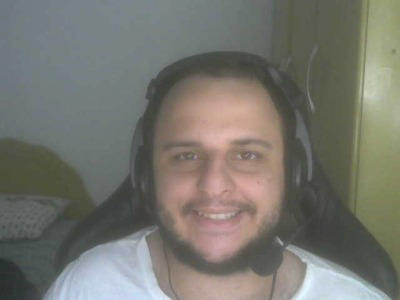

True

In [8]:
# Capturando foto

img = tirar_foto() # Clica na imagem para tirar uma foto 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)
cv2.imwrite("Foto-tirada.jpg", img)

[4.5933712e-06 8.1206464e-10 3.2533449e-06 9.9584407e-01 6.7828159e-06
 5.4159491e-06 4.1358443e-03]


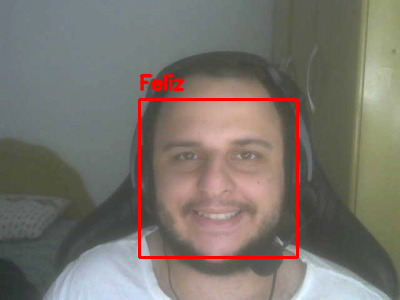

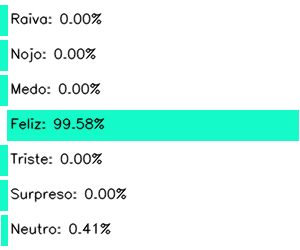

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
 
original = img.copy()
faces = face_detection.detectMultiScale(original,scaleFactor=1.1,minNeighbors=3,minSize=(20,20))
cinza = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
 
if len(faces) > 0:
    for (fX, fY, fW, fH) in faces:
      roi = cinza[fY:fY + fH, fX:fX + fW]
      roi = cv2.resize(roi, (48, 48))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      preds = classificador_emocoes.predict(roi)[0]
      print(preds)
      emotion_probability = np.max(preds)
      label = expressoes[preds.argmax()]
      cv2.putText(original, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2, cv2.LINE_AA)
      cv2.rectangle(original, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
else:
    print('Nenhuma face detectada')

 
cv2_imshow(original)

probabilidades = np.ones((250, 300, 3), dtype="uint8") * 255
# Mostra gráfico apenas se detectou uma face
if len(faces) == 1:
  for (i, (emotion, prob)) in enumerate(zip(expressoes, preds)):
      # Nome das emoções
      text = "{}: {:.2f}%".format(emotion, prob * 100)
      w = int(prob * 300)
      cv2.rectangle(probabilidades, (7, (i * 35) + 5),
      (w, (i * 35) + 35), (200, 250, 20), -1)
      cv2.putText(probabilidades, text, (10, (i * 35) + 23),
      cv2.FONT_HERSHEY_SIMPLEX, 0.45,
      (0, 0, 0), 1, cv2.LINE_AA)

  cv2_imshow(probabilidades)

cv2.imwrite("captura.jpg",original)
cv2.destroyAllWindows()